# People Analytics: Predicting Employee Turnover

#### Importing libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, \
    GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, recall_score, precision_score, \
    accuracy_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout
from keras.utils import to_categorical
import os
os.chdir(r'C:\Users\Nicolas\Documents\Scraping\hr_analytics')

### Importing and exploring the data

In [3]:
df = pd.read_csv('HR_comma_sep.csv')

In [4]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


Missing data

In [5]:
df.isnull().sum().sum()

0

Columns

In [6]:
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'sales', 'salary'],
      dtype='object')

Shape

In [7]:
df.shape

(14999, 10)

'Sales' column

In [8]:
df['sales'].value_counts()

sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: sales, dtype: int64

Overview

In [9]:
df.columns = df.columns.str.lower()

In [10]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


### Preprocessing

Making the sales column lowercase

In [11]:
df['sales'] = df['sales'].str.lower()

We will make dummy variables after making a preliminary exploration of the data

#### Functions for visuals

In [12]:
theme = '#6457A6'

def set_theme():
    return ax.set_facecolor(theme), \
    ax.grid(True, alpha=2e-1, color='white'), \
    ax.set_axisbelow(True)

### Preliminary analysis

#### Correlation matrix

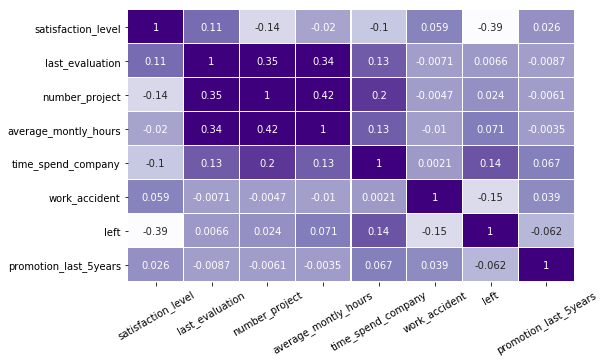

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))
g=sns.heatmap(df.corr(), annot=True, cbar=False, center=0, 
              cmap='Purples', vmin=-.3, vmax=0.3, linewidths=.1)
xticks = plt.xticks(rotation=30)

#### Satisfaction Level

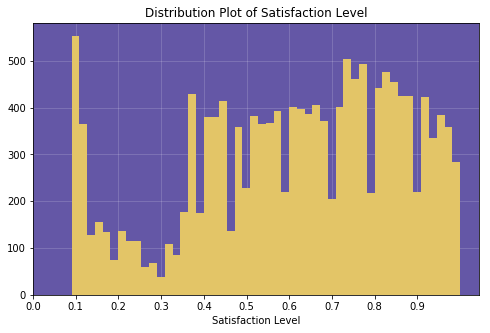

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(df['satisfaction_level'],
            bins=50, color='#E3C567')
plt.title('Distribution Plot of Satisfaction Level')
plt.xlabel('Satisfaction Level')
plt.xticks(np.arange(0, 1, 0.1))
set_theme()
plt.show()

We can see that the plurality (but not majority) of employees are greatly dissatisfied. Other than these, most employees seem rather satisfied. 

#### Last evaluation

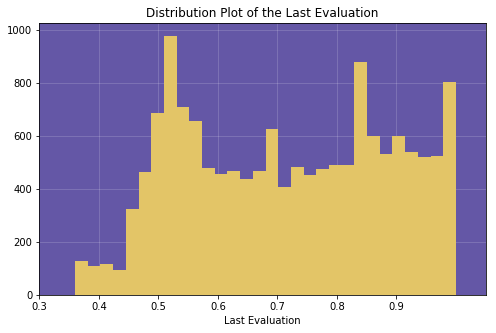

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(df['last_evaluation'],
            bins=30, color='#E3C567')
plt.title('Distribution Plot of the Last Evaluation')
plt.xlabel('Last Evaluation')
plt.xticks(np.arange(0, 1, 0.1))
plt.xlim(3e-1, 1.05)
set_theme()
plt.show()

From that, we can see that most people are rated above 0.5, and that there is a strong tendency towards the middle.

#### Number of Projects

In [16]:
df.corr()['number_project']

satisfaction_level      -0.142970
last_evaluation          0.349333
number_project           1.000000
average_montly_hours     0.417211
time_spend_company       0.196786
work_accident           -0.004741
left                     0.023787
promotion_last_5years   -0.006064
Name: number_project, dtype: float64

It's interesting to see that the more projects you commit to, the better your evaluation

The number of bins for the histogram will be the number of unique values:

In [17]:
bin_nb = df['number_project'].value_counts().shape[0]

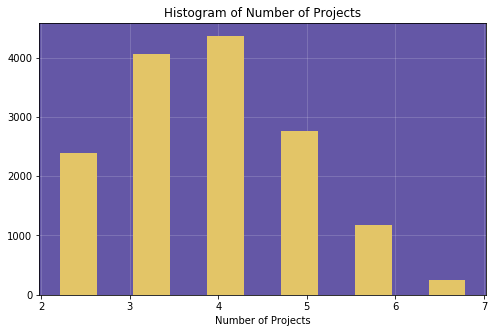

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(df['number_project'],
            bins=bin_nb, color='#E3C567', rwidth=0.5)
plt.title('Histogram of Number of Projects')
plt.xlabel('Number of Projects')
set_theme()
plt.show()

Interestingly, no one is doing only 1 project at the moment. Most are doing 3 to 4.

#### Average monthly hours

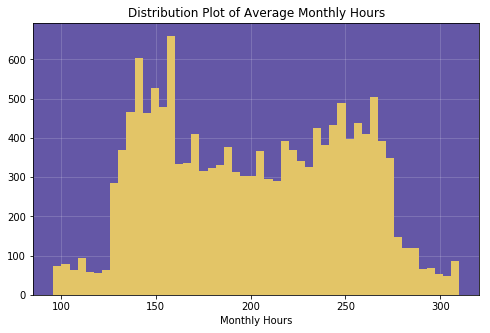

In [19]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(df['average_montly_hours'],
            bins=50, color='#E3C567')
plt.title('Distribution Plot of Average Monthly Hours')
plt.xlabel('Monthly Hours')
set_theme()
plt.show()

A large majority is working overtime (>160 hours).

#### Time Spent in Company

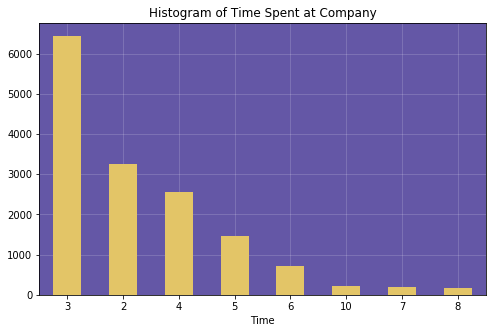

In [20]:
fig, ax = plt.subplots(figsize=(8, 5))
df['time_spend_company'].value_counts().plot(kind='bar', color='#E3C567')
plt.title('Histogram of Time Spent at Company')
plt.xlabel('Time')
plt.xticks(rotation=0)
set_theme()
plt.show()

Most people spent between 2 and 4 years at their company

#### Work accident

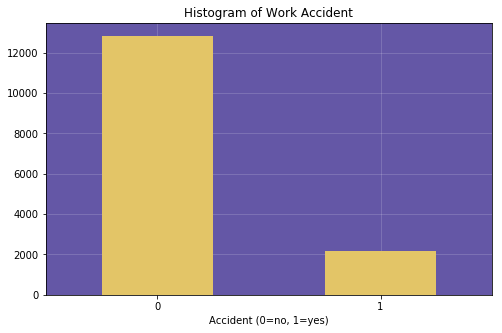

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))
df['work_accident'].value_counts().plot(kind='bar', color='#E3C567')
plt.title('Histogram of Work Accident')
plt.xlabel('Accident (0=no, 1=yes)')
plt.xticks([0, 1], rotation=0)
set_theme()
plt.show()

That's a substantial number of people

#### Left

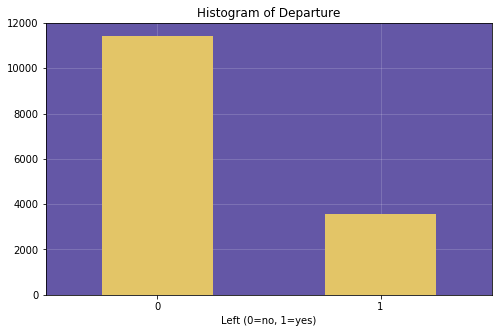

In [22]:
fig, ax = plt.subplots(figsize=(8, 5))
df['left'].value_counts().plot(kind='bar', color='#E3C567')
plt.title('Histogram of Departure')
plt.xlabel('Left (0=no, 1=yes)')
plt.xticks([0, 1], rotation=0)
set_theme()
plt.show()

So about one third of our sample left at the time data was collected

#### Promotion in the last 5 years

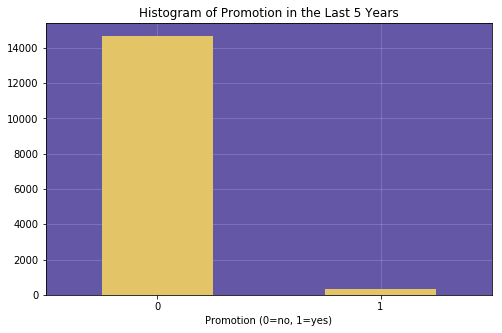

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))
df['promotion_last_5years'].value_counts().plot(kind='bar', color='#E3C567')
plt.title('Histogram of Promotion in the Last 5 Years')
plt.xlabel('Promotion (0=no, 1=yes)')
plt.xticks([0, 1], rotation=0)
set_theme()
plt.show()

Not many people were promoted recently

#### Sales

In [24]:
df['sales'].value_counts()

sales          4140
technical      2720
support        2229
it             1227
product_mng     902
marketing       858
randd           787
accounting      767
hr              739
management      630
Name: sales, dtype: int64

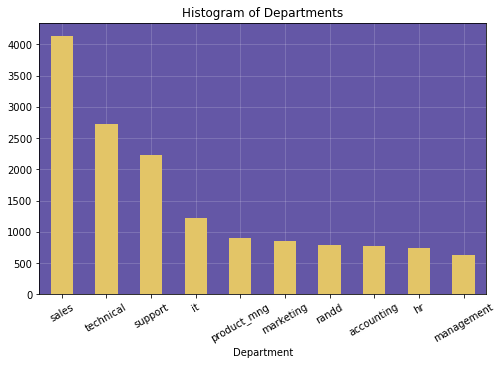

In [25]:
fig, ax = plt.subplots(figsize=(8, 5))
df['sales'].value_counts().plot(kind='bar', color='#E3C567')
plt.title('Histogram of Departments')
plt.xlabel('Department')
plt.xticks(rotation=30)
set_theme()
plt.show()

'randd' is research and development

#### Salary

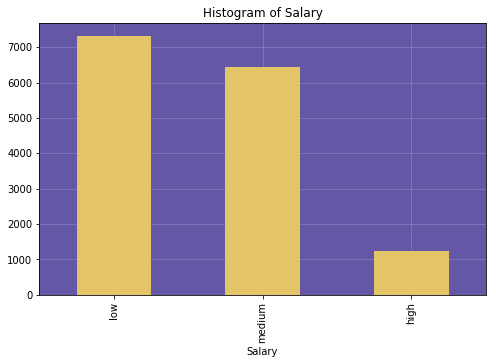

In [26]:
fig, ax = plt.subplots(figsize=(8, 5))
df['salary'].value_counts().plot(kind='bar', color='#E3C567')
plt.title('Histogram of Salary')
plt.xlabel('Salary')
set_theme()
plt.show()

Sad!

### Preparation for Analysis

#### One-hot encoding the categorical variables

Department

In [27]:
dummies_department = pd.get_dummies(df['sales'], prefix='dept')

In [28]:
df = pd.concat([df, dummies_department], axis=1, sort=False)

In [29]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,sales,salary,dept_accounting,dept_hr,dept_it,dept_management,dept_marketing,dept_product_mng,dept_randd,dept_sales,dept_support,dept_technical
0,0.38,0.53,2,157,3,0,1,0,sales,low,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,sales,medium,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,sales,low,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,sales,low,0,0,0,0,0,0,0,1,0,0


In [30]:
df.drop('sales', axis=1, inplace=True)

Salary

In [31]:
dummies_salary = pd.get_dummies(df['salary'], prefix='salary')

In [32]:
df = pd.concat([df, dummies_salary], axis=1, sort=False)

In [33]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,salary,dept_accounting,...,dept_management,dept_marketing,dept_product_mng,dept_randd,dept_sales,dept_support,dept_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,low,0,...,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,medium,0,...,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,medium,0,...,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,low,0,...,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,low,0,...,0,0,0,0,1,0,0,0,1,0


In [34]:
df.drop('salary', axis=1, inplace=True)

In [35]:
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'work_accident', 'left',
       'promotion_last_5years', 'dept_accounting', 'dept_hr', 'dept_it',
       'dept_management', 'dept_marketing', 'dept_product_mng', 'dept_randd',
       'dept_sales', 'dept_support', 'dept_technical', 'salary_high',
       'salary_low', 'salary_medium'],
      dtype='object')

#### Splitting the data into train/test sets

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('left', 
                axis=1), df['left'], test_size=2e-1, shuffle=True)

In [37]:
X_train.shape, X_test.shape

((11999, 20), (3000, 20))

For analysis, we have 20 columns. 12,000 instances to train the model, and 3,000 instances to test the model

## Predicting turnover

#### #1. Logistic Regression

In [38]:
logit = LogisticRegression(solver='lbfgs', max_iter=10_000)

In [39]:
logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [40]:
y_pred = logit.predict(X_test)

In [41]:
y_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int64)

Is the classifier only predicting non-departures?

In [42]:
counts = np.unique(y_pred, return_counts=True)[1]
counts

array([2574,  426], dtype=int64)

No

In [43]:
print('The classifier predicts a departure in %i%% of cases, compared'\
      ' to a real rate of 24%%.'%round(counts[1]*1e2/counts[0]))

The classifier predicts a departure in 17% of cases, compared to a real rate of 24%.


Evaluating the predictions:

In [44]:
confusion_matrix(y_test, y_pred)

array([[2138,  173],
       [ 436,  253]], dtype=int64)

In [45]:
recall_logit = recall_score(y_test, y_pred)
recall_logit

0.3671988388969521

In [46]:
print('%i%% of the people who left the company were predicted to do so.'%round(recall_logit*100))

37% of the people who left the company were predicted to do so.


In [47]:
precision_logit = precision_score(y_test, y_pred)
precision_logit

0.5938967136150235

In [48]:
print('%i%% of the people who didn\'t leave the company were predicted to do so.'%round(precision_logit*100))

59% of the people who didn't leave the company were predicted to do so.


In [49]:
f1_logit = f1_score(y_test, y_pred)
f1_logit

0.4538116591928251

In [50]:
print('f1 score: %i%%.'%round(f1_logit*100))

f1 score: 45%.


In [51]:
accuracy_logit = accuracy_score(y_test, y_pred)
accuracy_logit

0.797

In [52]:
print('%i%% of the people were classified in the correct category.'%round(accuracy_logit*100))

80% of the people were classified in the correct category.


In this case accuracy isn't too relevant because the classes are very imbalanced. An algorithm that would predict a non-departure in all cases would have the following accuracy:

In [53]:
print(str(round(df['left'].value_counts().iloc[0]/(df.shape[0]), 2)*100), '% accuracy')

76.0 % accuracy


So we gained 3% above this accuracy.

Grid Search for Hyperparameter Fine-Tuning

In [54]:
params = {'C':np.linspace(0.0001, 10, 1_00)}

In [55]:
logit_grid = GridSearchCV(logit, params, scoring='recall', cv=3, n_jobs=-1)

In [56]:
start_timer = time()
logit_grid.fit(X_train, y_train)
stop_timer = time()
print(round(stop_timer-start_timer), 'seconds')

32 seconds


In [57]:
logit_grid.best_score_

0.3487195275182921

We got a better recall score using the grid search

In [58]:
logit_grid.best_estimator_

LogisticRegression(C=4.242481818181818, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [59]:
y_pred = logit_grid.best_estimator_.predict(X_test)

In [60]:
recall_logit = recall_score(y_test, y_pred)
precision_logit = precision_score(y_test, y_pred)
f1_logit = f1_score(y_test, y_pred)
accuracy_logit = accuracy_score(y_test, y_pred)

Metrics dataframe. We will place recall score first because it's the most important, and accuracy last because it's the least informative. We might not even need to plot it

In [61]:
metrics_df = pd.DataFrame([recall_logit, precision_logit, 
                          f1_logit, accuracy_logit], 
                          columns=['Logit'],
                          index=['Recall', 'Precision', 
                                'F1 Score', 'Accuracy'])
metrics_df

,Logit
Recall,0.377358
Precision,0.599078
F1 Score,0.463045
Accuracy,0.799000


Metrics plot

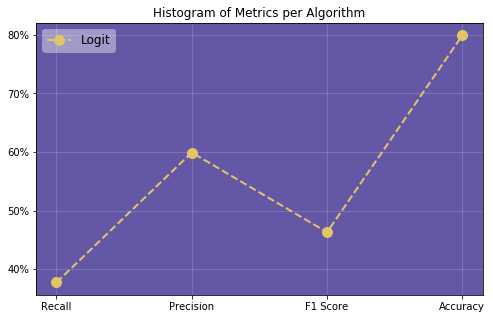

In [64]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(metrics_df.index, metrics_df.Logit, color='#E3C567', 
        marker='o', ms=10, linewidth=2, linestyle='dashed')

ax.legend(['Logit'], fontsize='large', framealpha=.4)
ax.set_yticklabels(['{:.0%}'.format(x) for x in ax.get_yticks()])
plt.title('Histogram of Metrics per Algorithm')
set_theme()
plt.show()

#### #2. Support Vector Machine (SVM)

In [73]:
svm = SVC(gamma='auto', kernel='rbf')

In [74]:
svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [75]:
y_pred = logit.predict(X_test)

In [76]:
y_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int64)

In [77]:
counts = np.unique(y_pred, return_counts=True)[1]
counts

array([2574,  426], dtype=int64)

In [78]:
print('The classifier predicts a departure in %i%% of cases, compared'\
      ' to a real rate of 24%%.'%round(counts[1]*1e2/counts[0]))

The classifier predicts a departure in 17% of cases, compared to a real rate of 24%.


Evaluating the predictions:

In [79]:
confusion_matrix(y_test, y_pred)

array([[2138,  173],
       [ 436,  253]], dtype=int64)

In [80]:
recall_svm = recall_score(y_test, y_pred)
recall_svm

0.3671988388969521

In [81]:
print('%i%% of the people who left the company were predicted to do so.'%round(recall_svm*100))

37% of the people who left the company were predicted to do so.


In [82]:
precision_svm = precision_score(y_test, y_pred)
precision_svm

0.5938967136150235

In [83]:
print('%i%% of the people who didn\'t leave the company were predicted to do so.'%round(precision_svm*100))

59% of the people who didn't leave the company were predicted to do so.


In [84]:
f1_svm = f1_score(y_test, y_pred)
f1_svm

0.4538116591928251

In [85]:
print('f1 score: %i%%.'%round(f1_svm*100))

f1 score: 45%.


In [86]:
accuracy_svm = accuracy_score(y_test, y_pred)
accuracy_svm

0.797

In [87]:
print('%i%% of the people were classified in the correct category.'%round(accuracy_svm*100))

80% of the people were classified in the correct category.


Grid Search for Hyperparameter Fine-Tuning

In [88]:
params = {'C':np.linspace(7, 8, 1_0),
          'gamma':np.linspace(7, 8, 1_0)
         }

In [89]:
svm_grid = RandomizedSearchCV(svm, params, scoring='recall', cv=3, verbose=0,
                              n_jobs=-1, n_iter=10, return_train_score=True)

In [90]:
start_timer = time()
svm_grid.fit(X_train, y_train)
stop_timer = time()
print(round(stop_timer-start_timer)/60, 'minutes')

3.85 minutes


In [91]:
svm_grid.best_score_

0.6488538909524979

We got a better recall score using the grid search

In [92]:
svm_grid.best_estimator_

SVC(C=7.666666666666667, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=7.777777777777778,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [93]:
start_timer = time()
svm_grid = SVC(C=7.6, gamma=7.2, kernel='rbf', degree=3)
svm_grid.fit(X_train, y_train)
stop_timer = time()
print(round(stop_timer-start_timer)/60, 'minutes')

0.85 minutes


In [94]:
y_pred = svm_grid.predict(X_test)

In [95]:
recall_svm = recall_score(y_test, y_pred)
precision_svm = precision_score(y_test, y_pred)
f1_svm = f1_score(y_test, y_pred)
accuracy_svm = accuracy_score(y_test, y_pred)

Metrics dataframe

In [96]:
metrics_svm = pd.DataFrame([recall_svm, precision_svm, 
                          f1_svm, accuracy_svm], 
                          columns=['SVM'],
                          index=['Recall', 'Precision', 
                                'F1 Score', 'Accuracy'])
metrics_df = pd.concat([metrics_df, metrics_svm], axis=1, sort=False)
metrics_df

,Logit,SVM
Recall,0.377358,0.785196
Precision,0.599078,0.987226
F1 Score,0.463045,0.874697
Accuracy,0.799000,0.948333


Metrics plot

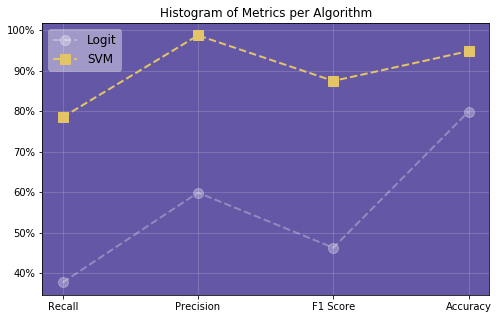

In [97]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(metrics_df.index, metrics_df['Logit'], color='white', 
        marker='o', ms=10, linewidth=2, linestyle='dashed', alpha=0.3)

ax.plot(metrics_df.index, metrics_df['SVM'], color='#E3C567', 
        marker='s', ms=10, linewidth=2, linestyle='dashed')

ax.legend(['Logit', 'SVM'], fontsize='large', framealpha=.4)
ax.set_yticklabels(['{:.0%}'.format(x) for x in ax.get_yticks()])
plt.title('Histogram of Metrics per Algorithm')
set_theme()
plt.show()

#### #3. Gaussian Naïve Bayes

In [98]:
gnb = GaussianNB()

In [99]:
gnb.fit(X_train, y_train)

GaussianNB(priors=None)

In [100]:
y_pred = gnb.predict(X_test)

In [101]:
y_pred[:10]

array([0, 1, 1, 1, 1, 0, 0, 1, 0, 1], dtype=int64)

In [102]:
counts = np.unique(y_pred, return_counts=True)[1]
counts

array([1557, 1443], dtype=int64)

In [103]:
print('The classifier predicts a departure in %i%% of cases, compared'\
      ' to a real rate of 24%%.'%round(counts[1]*1e2/counts[0]))

The classifier predicts a departure in 93% of cases, compared to a real rate of 24%.


Evaluating the predictions:

In [104]:
confusion_matrix(y_test, y_pred)

array([[1423,  888],
       [ 134,  555]], dtype=int64)

In [105]:
recall_gnb = recall_score(y_test, y_pred)
recall_gnb

0.8055152394775036

In [106]:
print('%i%% of the people who left the company were predicted to do so.'%round(recall_gnb*100))

81% of the people who left the company were predicted to do so.


In [107]:
precision_gnb = precision_score(y_test, y_pred)
precision_gnb

0.38461538461538464

In [108]:
print('%i%% of the people who didn\'t leave the company were predicted to do so.'%round(precision_gnb*100))

38% of the people who didn't leave the company were predicted to do so.


In [109]:
f1_gnb = f1_score(y_test, y_pred)
f1_gnb

0.5206378986866792

In [110]:
print('f1 score: %i%%.'%round(f1_gnb*100))

f1 score: 52%.


In [111]:
accuracy_gnb = accuracy_score(y_test, y_pred)
accuracy_gnb

0.6593333333333333

In [112]:
print('%i%% of the people were classified in the correct category.'%round(accuracy_gnb*100))

66% of the people were classified in the correct category.


Metrics dataframe

In [113]:
metrics_gnb = pd.DataFrame([recall_gnb, precision_gnb, 
                          f1_gnb, accuracy_gnb], 
                          columns=['Naïve Bayes'],
                          index=['Recall', 'Precision', 
                                'F1 Score', 'Accuracy'])
metrics_df = pd.concat([metrics_df, metrics_gnb], axis=1, sort=False)
metrics_df

,Logit,SVM,Naïve Bayes
Recall,0.377358,0.785196,0.805515
Precision,0.599078,0.987226,0.384615
F1 Score,0.463045,0.874697,0.520638
Accuracy,0.799000,0.948333,0.659333


Metrics plot

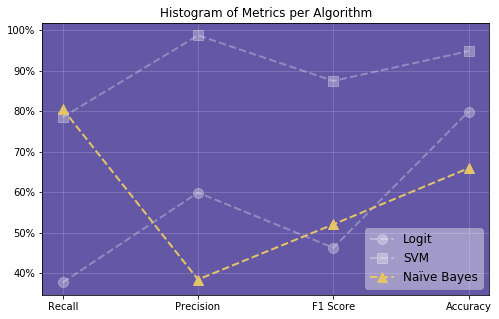

In [114]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(metrics_df.index, metrics_df['Logit'], color='white', 
        marker='o', ms=10, linewidth=2, linestyle='dashed', alpha=0.3)

ax.plot(metrics_df.index, metrics_df['SVM'], color='white', 
        marker='s', ms=10, linewidth=2, linestyle='dashed', alpha=0.3)

ax.plot(metrics_df.index, metrics_df['Naïve Bayes'], color='#E3C567', 
        marker='^', ms=10, linewidth=2, linestyle='dashed')

ax.legend(['Logit', 'SVM', 'Naïve Bayes'], fontsize='large', framealpha=.4)
ax.set_yticklabels(['{:.0%}'.format(x) for x in ax.get_yticks()])
plt.title('Histogram of Metrics per Algorithm')
set_theme()
plt.show()

#### #4. Decision Tree Classifier

In [115]:
tree = DecisionTreeClassifier()

In [116]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [117]:
y_pred = tree.predict(X_test)

In [118]:
y_pred[:10]

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 1], dtype=int64)

In [119]:
counts = np.unique(y_pred, return_counts=True)[1]
counts

array([2298,  702], dtype=int64)

In [120]:
print('The classifier predicts a departure in %i%% of cases, compared'\
      ' to a real rate of 24%%.'%round(counts[1]*1e2/counts[0]))

The classifier predicts a departure in 31% of cases, compared to a real rate of 24%.


Evaluating the predictions:

In [121]:
confusion_matrix(y_test, y_pred)

array([[2277,   34],
       [  21,  668]], dtype=int64)

In [122]:
recall_tree = recall_score(y_test, y_pred)
recall_tree

0.969521044992743

In [123]:
print('%i%% of the people who left the company were predicted to do so.'%round(recall_tree*100))

97% of the people who left the company were predicted to do so.


In [124]:
precision_tree = precision_score(y_test, y_pred)
precision_tree

0.9515669515669516

In [125]:
print('%i%% of the people who didn\'t leave the company were predicted to do so.'%round(precision_tree*100))

95% of the people who didn't leave the company were predicted to do so.


In [126]:
f1_tree = f1_score(y_test, y_pred)
f1_tree

0.9604601006470165

In [127]:
print('f1 score: %i%%.'%round(f1_tree*100))

f1 score: 96%.


In [128]:
accuracy_tree = accuracy_score(y_test, y_pred)
accuracy_tree

0.9816666666666667

In [129]:
print('%i%% of the people were classified in the correct category.'%round(accuracy_tree*100))

98% of the people were classified in the correct category.


Grid Search for Hyperparameter Fine-Tuning

In [130]:
tree.get_params().keys()

dict_keys(['class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [131]:
params = {'max_depth':np.arange(4, 15),
          'max_features':np.arange(2, df.columns.shape[0]),
          'min_samples_split':np.arange(10, 100, 10),
          'min_impurity_decrease':np.arange(0.01, 0.1, 0.01)
         }

In [133]:
tree_grid = RandomizedSearchCV(tree, params, scoring='recall', cv=3, verbose=0,
                              n_jobs=-1, n_iter=1_000, return_train_score=True)

In [134]:
start_timer = time()
tree_grid.fit(X_train, y_train)
stop_timer = time()
print(round(stop_timer-start_timer), 'seconds')

18 seconds


In [135]:
tree_grid.best_score_

0.9396186604476838

We got a better recall score using the grid search

In [136]:
tree_grid.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=8, max_leaf_nodes=None,
            min_impurity_decrease=0.01, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [137]:
y_pred = tree_grid.best_estimator_.predict(X_test)

In [138]:
recall_tree = recall_score(y_test, y_pred)
precision_tree = precision_score(y_test, y_pred)
f1_tree = f1_score(y_test, y_pred)
accuracy_tree = accuracy_score(y_test, y_pred)

Plotting the decision tree

In [139]:
X_train.columns.values

array(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'work_accident',
       'promotion_last_5years', 'dept_accounting', 'dept_hr', 'dept_it',
       'dept_management', 'dept_marketing', 'dept_product_mng',
       'dept_randd', 'dept_sales', 'dept_support', 'dept_technical',
       'salary_high', 'salary_low', 'salary_medium'], dtype=object)

In [140]:
export_graphviz(
    tree,
    out_file=r'C:\Users\Nicolas\Anaconda3\pkgs\graphviz-2.38-hfd603c8_2\Library\bin/graphviz/hr_tree.dot',
    feature_names=X_train.columns,
    class_names=y_train.unique().astype(str),
    rounded=True,
    max_depth=2,
    filled=True,
    rotate=True)

In [141]:
# type this into the command line: 
# dot -Tpng C:\Users\Nicolas\Anaconda3\pkgs\graphviz-2.38-hfd603c8_2\Library\bin\graphviz/hr_tree.dot -o 
# C:\Users\Nicolas\Anaconda3\pkgs\graphviz-2.38-hfd603c8_2\Library\bin\graphviz/hr_tree.jpg

In [142]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 400

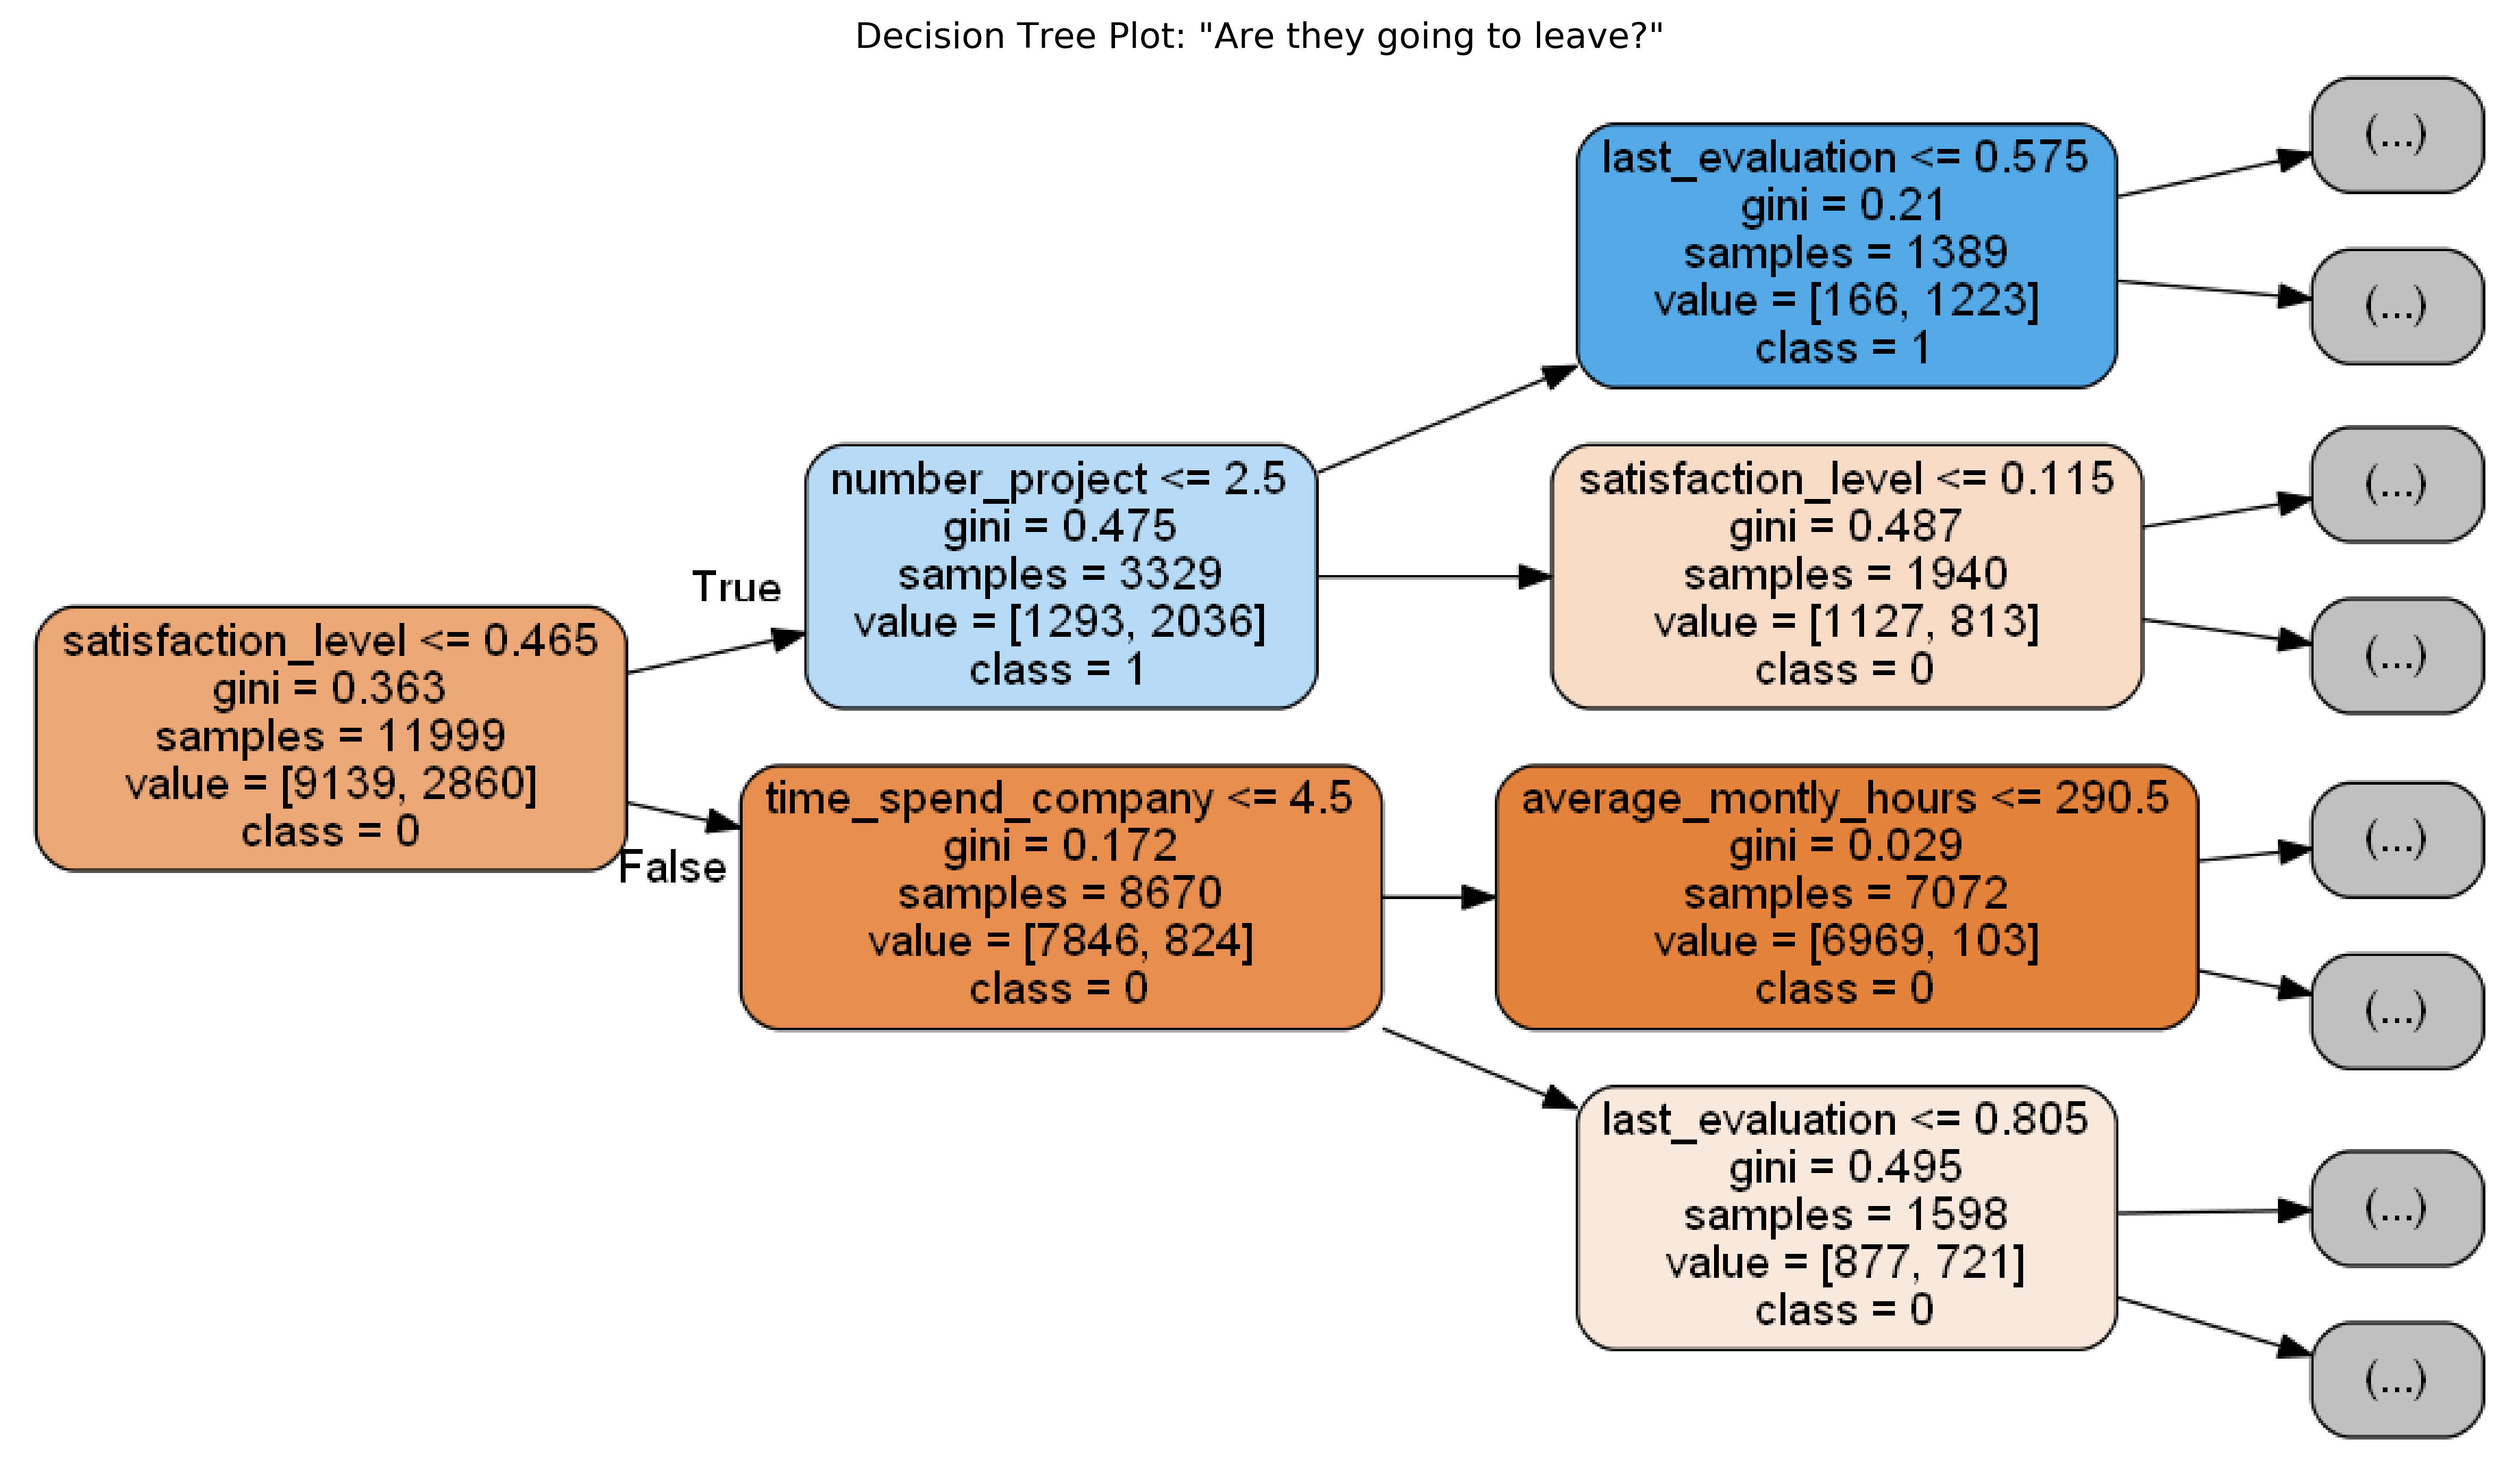

In [143]:
tree_plot = plt.imread(r'C:\Users\Nicolas\Anaconda3\pkgs\graphviz-2.38-hfd603c8_2\Library\bin\graphviz/hr_tree.jpg')
plt.figure(figsize=(15,15))
plt.grid(None, alpha=0)
plt.axis('off')
plt.title('Decision Tree Plot: "Are they going to leave?"')
plt.xticks([]), plt.yticks([])
show=plt.imshow(tree_plot, interpolation='nearest')

Above, you can see the decision tree. For instance, here's someone who's likely to leave: satisfaction level under 0.465, number of projects under 2.5, last evaluation under 5.75, etc

Inspecting the importance of various features

In [144]:
imp = pd.DataFrame(tree.feature_importances_, index=[X_train.columns], 
             columns=['Importance']).sort_values(by='Importance', ascending=False)
imp.head()

,Importance
satisfaction_level,0.493014
last_evaluation,0.147394
time_spend_company,0.144354
number_project,0.103512
average_montly_hours,0.093152


We can see that the satisfaction level is the most important feature

Metrics dataframe

In [145]:
metrics_tree = pd.DataFrame([recall_tree, precision_tree, 
                          f1_tree, accuracy_tree], 
                          columns=['Decision Tree'],
                          index=['Recall', 'Precision', 
                                'F1 Score', 'Accuracy'])
metrics_df = pd.concat([metrics_df, metrics_tree], axis=1, sort=False)
metrics_df

,Logit,SVM,Naïve Bayes,Decision Tree
Recall,0.377358,0.785196,0.805515,0.921626
Precision,0.599078,0.987226,0.384615,0.847797
F1 Score,0.463045,0.874697,0.520638,0.883171
Accuracy,0.799000,0.948333,0.659333,0.944000


Metrics plot

In [147]:
mpl.rcParams['figure.dpi']= 75

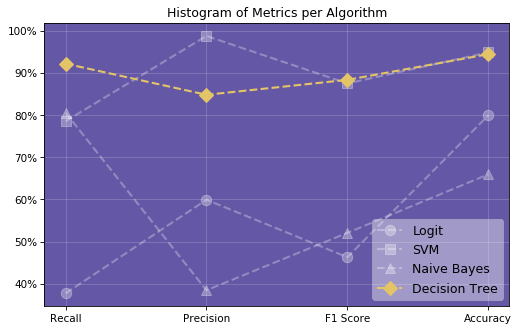

In [148]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(metrics_df.index, metrics_df['Logit'], color='white', 
        marker='o', ms=10, linewidth=2, linestyle='dashed', alpha=0.3)

ax.plot(metrics_df.index, metrics_df['SVM'], color='white', 
        marker='s', ms=10, linewidth=2, linestyle='dashed', alpha=0.3)

ax.plot(metrics_df.index, metrics_df['Naïve Bayes'], color='white', 
        marker='^', ms=10, linewidth=2, linestyle='dashed', alpha=0.3)

ax.plot(metrics_df.index, metrics_df['Decision Tree'], color='#E3C567', 
        marker='D', ms=10, linewidth=2, linestyle='dashed')

ax.legend(['Logit', 'SVM', 'Naive Bayes', 'Decision Tree'], 
          fontsize='large', framealpha=.4, loc='lower right')
ax.set_yticklabels(['{:.0%}'.format(x) for x in ax.get_yticks()])
plt.title('Histogram of Metrics per Algorithm')
set_theme()
plt.show()

So far the best model is the decision tree. The most important metric here is either the recall score, or the f1 score, which is a weighted mixture of precision and recall. It largely depends how a manager would want to isolate a target group. Would you end up with a large samples, with 80% of the people who will potentially quit, or a small sample containing only people who will definitely quit, but missing many more? 

#### #5. Multi-Layer Perceptron Classifier (Neural Network)

In [199]:
net = MLPClassifier(hidden_layer_sizes=(24, 48), batch_size=8,
                   activation='relu', solver='adam',
                   early_stopping=True)

In [200]:
net.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size=8, beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(24, 48), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [201]:
y_pred = net.predict(X_test)

In [202]:
y_pred[:10]

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 1], dtype=int64)

In [203]:
counts = np.unique(y_pred, return_counts=True)[1]
counts

array([2178,  822], dtype=int64)

In [204]:
print('The classifier predicts a departure in %i%% of cases, compared'\
      ' to a real rate of 24%%.'%round(counts[1]*1e2/counts[0]))

The classifier predicts a departure in 38% of cases, compared to a real rate of 24%.


Evaluating the predictions:

In [205]:
confusion_matrix(y_test, y_pred)

array([[2064,  247],
       [ 114,  575]], dtype=int64)

In [206]:
recall_net = recall_score(y_test, y_pred)
recall_net

0.8345428156748912

In [207]:
print('%i%% of the people who left the company were predicted to do so.'%round(recall_net*100))

83% of the people who left the company were predicted to do so.


In [208]:
precision_net = precision_score(y_test, y_pred)
precision_net

0.6995133819951338

In [209]:
print('%i%% of the people who didn\'t leave the company were predicted to do so.'%round(precision_net*100))

70% of the people who didn't leave the company were predicted to do so.


In [210]:
f1_net = f1_score(y_test, y_pred)
f1_net

0.7610853739245533

In [211]:
print('f1 score: %i%%.'%round(f1_net*100))

f1 score: 76%.


In [212]:
accuracy_net = accuracy_score(y_test, y_pred)
accuracy_net

0.8796666666666667

In [213]:
print('%i%% of the people were classified in the correct category.'%round(accuracy_net*100))

88% of the people were classified in the correct category.


Grid Search for Hyperparameter Fine-Tuning

In [214]:
params = {'alpha':np.linspace(0.00005, 0.0001, 5),
          'hidden_layer_sizes':[(32, 64), (64, 128)],
          'batch_size':[8, 16, 24, 32, 64, 100]
         }

In [217]:
net_grid = RandomizedSearchCV(net, params, scoring='recall', cv=3, verbose=0,
                              n_jobs=-1, n_iter=50, return_train_score=True)

In [218]:
start_timer = time()
net_grid.fit(X_train, y_train)
stop_timer = time()
print(round(stop_timer-start_timer)/60, 'minutes')

2.8666666666666667 minutes


In [219]:
net_grid.best_score_

0.8681382194288824

In [220]:
net_grid.best_params_

{'hidden_layer_sizes': (32, 64), 'batch_size': 8, 'alpha': 0.0001}

We did NOT get a better recall score using the grid search

Metrics dataframe

In [221]:
metrics_net = pd.DataFrame([recall_net, precision_net, 
                          f1_net, accuracy_net], 
                          columns=['MLP'],
                          index=['Recall', 'Precision', 
                                'F1 Score', 'Accuracy'])
metrics_df = pd.concat([metrics_df, metrics_net], axis=1, sort=False)
metrics_df

,Logit,SVM,Naïve Bayes,Decision Tree,MLP
Recall,0.377358,0.785196,0.805515,0.921626,0.834543
Precision,0.599078,0.987226,0.384615,0.847797,0.699513
F1 Score,0.463045,0.874697,0.520638,0.883171,0.761085
Accuracy,0.799000,0.948333,0.659333,0.944000,0.879667


Metrics plot

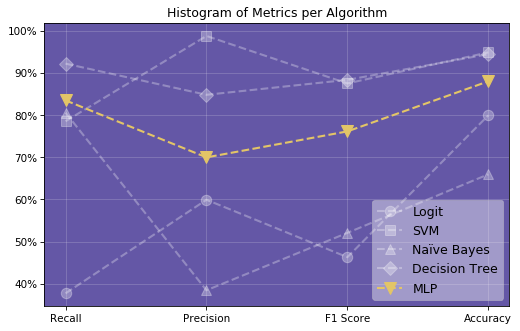

In [223]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(metrics_df.index, metrics_df['Logit'], color='white', 
        marker='o', ms=10, linewidth=2, linestyle='dashed', alpha=0.3)

ax.plot(metrics_df.index, metrics_df['SVM'], color='white', 
        marker='s', ms=10, linewidth=2, linestyle='dashed', alpha=0.3)

ax.plot(metrics_df.index, metrics_df['Naïve Bayes'], color='white', 
        marker='^', ms=10, linewidth=2, linestyle='dashed', alpha=0.3)

ax.plot(metrics_df.index, metrics_df['Decision Tree'], color='white', 
        marker='D', ms=10, linewidth=2, linestyle='dashed', alpha=0.3)

ax.plot(metrics_df.index, metrics_df['MLP'], color='#E3C567', 
        marker='v', ms=12, linewidth=2, linestyle='dashed')

ax.legend(['Logit', 'SVM', 'Naïve Bayes', 'Decision Tree', 'MLP'], 
          fontsize='large', framealpha=.4, loc='lower right')
ax.set_yticklabels(['{:.0%}'.format(x) for x in ax.get_yticks()])
plt.title('Histogram of Metrics per Algorithm')
set_theme()
plt.show()

#### #6. Random Forest Classifier

In [224]:
rf = RandomForestClassifier(n_estimators=1_00, n_jobs=-1)

In [225]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [226]:
y_pred = rf.predict(X_test)

In [227]:
y_pred[:10]

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 1], dtype=int64)

In [228]:
counts = np.unique(y_pred, return_counts=True)[1]
counts

array([2326,  674], dtype=int64)

In [229]:
print('The classifier predicts a departure in %i%% of cases, compared'\
      ' to a real rate of 24%%.'%round(counts[1]*1e2/counts[0]))

The classifier predicts a departure in 29% of cases, compared to a real rate of 24%.


Evaluating the predictions:

In [230]:
confusion_matrix(y_test, y_pred)

array([[2304,    7],
       [  22,  667]], dtype=int64)

In [231]:
recall_rf = recall_score(y_test, y_pred)
recall_rf

0.9680696661828737

In [232]:
print('%i%% of the people who left the company were predicted to do so.'%round(recall_rf*100))

97% of the people who left the company were predicted to do so.


In [233]:
precision_rf = precision_score(y_test, y_pred)
precision_rf

0.9896142433234422

In [234]:
print('%i%% of the people who didn\'t leave the company were predicted to do so.'%round(precision_rf*100))

99% of the people who didn't leave the company were predicted to do so.


In [235]:
f1_rf = f1_score(y_test, y_pred)
f1_rf

0.9787234042553191

In [236]:
print('f1 score: %i%%.'%round(f1_net*100))

f1 score: 76%.


In [237]:
accuracy_rf = accuracy_score(y_test, y_pred)
accuracy_rf

0.9903333333333333

In [238]:
print('%i%% of the people were classified in the correct category.'%round(accuracy_rf*100))

99% of the people were classified in the correct category.


Grid Search for Hyperparameter Fine-Tuning

In [239]:
params = {'max_features':np.arange(6, X_train.shape[1]),
          'min_impurity_decrease':np.linspace(0, .01, 10),
          'min_samples_split':np.arange(10, 100, 10)
         }

In [240]:
rf_grid = RandomizedSearchCV(rf, params, scoring='recall', cv=3, verbose=1,
                              n_jobs=-1, n_iter=50, return_train_score=True)

In [241]:
start_timer = time()
rf_grid.fit(X_train, y_train)
stop_timer = time()
print(round(stop_timer-start_timer), 'seconds')

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   39.3s finished


40 seconds


In [242]:
rf_grid.best_score_

0.9240108149621208

In [243]:
rf_grid.best_params_

{'min_samples_split': 30, 'min_impurity_decrease': 0.0, 'max_features': 14}

We did NOT get a better recall score using the grid search

Metrics dataframe

In [244]:
metrics_rf = pd.DataFrame([recall_rf, precision_rf, 
                          f1_rf, accuracy_rf], 
                          columns=['Random Forest'],
                          index=['Recall', 'Precision', 
                                'F1 Score', 'Accuracy'])
metrics_df = pd.concat([metrics_df, metrics_rf], axis=1, sort=False)
metrics_df

,Logit,SVM,Naïve Bayes,Decision Tree,MLP,Random Forest
Recall,0.377358,0.785196,0.805515,0.921626,0.834543,0.968070
Precision,0.599078,0.987226,0.384615,0.847797,0.699513,0.989614
F1 Score,0.463045,0.874697,0.520638,0.883171,0.761085,0.978723
Accuracy,0.799000,0.948333,0.659333,0.944000,0.879667,0.990333


Metrics plot

In [245]:
mpl.rcParams['figure.dpi']= 75

<font color='red'>__ATTENTION:__</font> We will start removing the weaker models from the plot

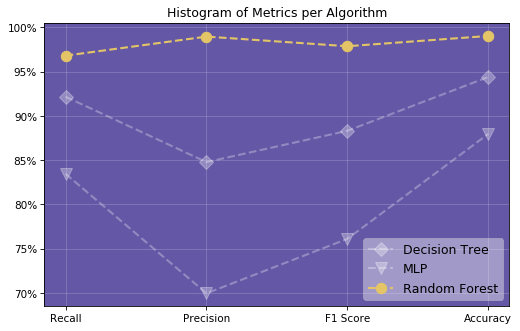

In [246]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(metrics_df.index, metrics_df['Decision Tree'], color='white', 
        marker='D', ms=10, linewidth=2, linestyle='dashed', alpha=0.3)

ax.plot(metrics_df.index, metrics_df['MLP'], color='white', 
        marker='v', ms=12, linewidth=2, linestyle='dashed', alpha=0.3)

ax.plot(metrics_df.index, metrics_df['Random Forest'], color='#E3C567', 
        marker='o', ms=10, linewidth=2, linestyle='dashed')

ax.legend(['Decision Tree', 'MLP', 'Random Forest'], 
          fontsize='large', framealpha=.4, loc='lower right')
ax.set_yticklabels(['{:.0%}'.format(x) for x in ax.get_yticks()])
plt.title('Histogram of Metrics per Algorithm')
set_theme()
plt.show()

So far, the random forest is the best algorithm, by a _large_ margin

#### #7. Voting Classifier

In [247]:
voting = VotingClassifier([('dt', tree), ('mlp', net), ('rf', rf)], voting='hard')

In [248]:
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [254]:
y_pred = voting.predict(X_test)

C:\Users\Nicolas\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [255]:
y_pred[:10]

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 1], dtype=int64)

In [256]:
counts = np.unique(y_pred, return_counts=True)[1]
counts

array([2318,  682], dtype=int64)

In [257]:
print('The classifier predicts a departure in %i%% of cases, compared'\
      ' to a real rate of 24%%.'%round(counts[1]*1e2/counts[0]))

The classifier predicts a departure in 29% of cases, compared to a real rate of 24%.


Evaluating the predictions:

In [258]:
confusion_matrix(y_test, y_pred)

array([[2297,   14],
       [  21,  668]], dtype=int64)

In [259]:
recall_voting = recall_score(y_test, y_pred)
recall_voting

0.969521044992743

In [260]:
print('%i%% of the people who left the company were predicted to do so.'%round(recall_voting*100))

97% of the people who left the company were predicted to do so.


In [261]:
precision_voting = precision_score(y_test, y_pred)
precision_voting

0.9794721407624634

In [262]:
print('%i%% of the people who didn\'t leave the company were predicted to do so.'%round(precision_voting*100))

98% of the people who didn't leave the company were predicted to do so.


In [263]:
f1_voting = f1_score(y_test, y_pred)
f1_voting

0.974471188913202

In [264]:
print('f1 score: %i%%.'%round(f1_voting*100))

f1 score: 97%.


In [265]:
accuracy_voting = accuracy_score(y_test, y_pred)
accuracy_voting

0.9883333333333333

In [266]:
print('%i%% of the people were classified in the correct category.'%round(accuracy_voting*100))

99% of the people were classified in the correct category.


Grid Search for Hyperparameter Fine-Tuning

In [267]:
params = {'voting':['soft', 'hard']}

In [271]:
voting_grid = RandomizedSearchCV(voting, params, scoring='recall', cv=3, verbose=0,
                              n_jobs=-1, return_train_score=True, n_iter=2)

In [272]:
start_timer = time()
voting_grid.fit(X_train, y_train)
stop_timer = time()
print(round(stop_timer-start_timer), 'seconds')

19 seconds


In [273]:
voting_grid.best_score_

0.9531575209202744

In [274]:
voting_grid.best_params_

{'voting': 'hard'}

We did NOT get a better recall score using the grid search

Metrics dataframe

In [275]:
metrics_voting = pd.DataFrame([recall_voting, precision_voting, 
                          f1_voting, accuracy_voting], 
                          columns=['Voting Classifier'],
                          index=['Recall', 'Precision', 
                                'F1 Score', 'Accuracy'])
metrics_df = pd.concat([metrics_df, metrics_voting], axis=1, sort=False)
metrics_df

,Logit,SVM,Naïve Bayes,Decision Tree,MLP,Random Forest,Voting Classifier
Recall,0.377358,0.785196,0.805515,0.921626,0.834543,0.968070,0.969521
Precision,0.599078,0.987226,0.384615,0.847797,0.699513,0.989614,0.979472
F1 Score,0.463045,0.874697,0.520638,0.883171,0.761085,0.978723,0.974471
Accuracy,0.799000,0.948333,0.659333,0.944000,0.879667,0.990333,0.988333


<font color='red'>__ATTENTION:__</font> Seems like we hit the peak of ensemble methods, so we will not add this model to the plot. We will move on to the next step: neural networks with Tensorflow. In the meantime, here's the performance of our models so far.

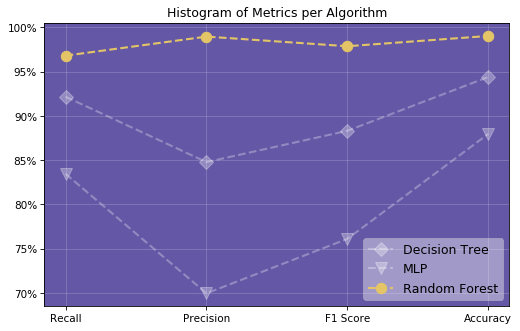

In [276]:
fig, ax = plt.subplots(figsize=(8, 5))

'''ax.plot(metrics_df.index, metrics_df['SVM'], color='white', 
        marker='s', ms=10, linewidth=2, linestyle='dashed', alpha=0.3)'''

'''ax.plot(metrics_df.index, metrics_df['Naive Bayes'], color='white', 
        marker='^', ms=10, linewidth=2, linestyle='dashed', alpha=0.3)'''

ax.plot(metrics_df.index, metrics_df['Decision Tree'], color='white', 
        marker='D', ms=10, linewidth=2, linestyle='dashed', alpha=0.3)

ax.plot(metrics_df.index, metrics_df['MLP'], color='white', 
        marker='v', ms=12, linewidth=2, linestyle='dashed', alpha=0.3)

ax.plot(metrics_df.index, metrics_df['Random Forest'], color='#E3C567', 
        marker='o', ms=10, linewidth=2, linestyle='dashed')

ax.legend(['Decision Tree', 'MLP', 'Random Forest'], 
          fontsize='large', framealpha=.4, loc='lower right')
ax.set_yticklabels(['{:.0%}'.format(x) for x in ax.get_yticks()])
plt.title('Histogram of Metrics per Algorithm')
set_theme()
plt.show()

#### #8. Fully Connected Neural Network

In [277]:
scaler = MinMaxScaler()

In [278]:
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

In [279]:
y_train = np.array(y_train.astype(np.float32))
y_test = np.array(y_test.astype(np.float32))

In [280]:
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

Model parameters

In [281]:
input_shape = X_train.shape[1]
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=25, restore_best_weights=True)

Building the model

In [284]:
model = Sequential([
    Dense(48, input_shape=(input_shape,)),
    Dense(96, activation='relu'),
    Dropout(5e-1),
    Dense(2, activation='sigmoid')
    ])

Compiling the model

In [285]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['categorical_accuracy'])

In [286]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 48)                1008      
_________________________________________________________________
dense_4 (Dense)              (None, 96)                4704      
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 194       
Total params: 5,906
Trainable params: 5,906
Non-trainable params: 0
_________________________________________________________________


Training the model

In [287]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    validation_data=[X_test, y_test], 
                    batch_size=8,
                    verbose=1,
                    callbacks=[early_stopping])

Train on 11999 samples, validate on 3000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
11999/11999 [==============================] - 7s 597us/sample - loss: 0.3982 - categorical_accuracy: 0.8181 - val_loss: 0.2255 - val_categorical_accuracy: 0.9150
Epoch 2/100
11999/11999 [==============================] - 8s 626us/sample - loss: 0.2098 - categorical_accuracy: 0.9297 - val_loss: 0.1664 - val_categorical_accuracy: 0.9473
Epoch 3/100
11999/11999 [==============================] - 7s 559us/sample - loss: 0.1871 - categorical_accuracy: 0.9430 - val_loss: 0.1552 - val_categorical_accuracy: 0.9507
Epoch 4/100
11999/11999 [==============================] - 7s 568us/sample - loss: 0.1852 - categorical_accuracy: 0.9443 - val_loss: 0.1523 - val_categorical_accuracy: 0.9507
Epoch 5/100
11999/11999 [==============================] - 7s 568us/sample - loss: 0.1823 - categorical_accuracy: 0.9443 - val_loss: 0.1534 - val_categorical_accuracy: 0.9523
Epoch 6/100
11999/11999 [===

In [288]:
eval = model.evaluate(X_test, y_test)

3000/3000 [==============================] - 0s 59us/sample - loss: 0.1247 - categorical_accuracy: 0.9610


In [289]:
print('The final loss is %f and the final accuracy is %i%%.'%(eval[0], eval[1]*100))

The final loss is 0.124727 and the final accuracy is 96%.


In [290]:
y_pred = model.predict(X_test)

In [291]:
y_pred = np.array(y_pred[:, 0] > .5, dtype=np.float32)*1
y_pred[:10]

array([1., 0., 1., 1., 1., 1., 1., 0., 1., 0.], dtype=float32)

In [292]:
counts = np.unique(y_pred, return_counts=True)[1]
counts

array([ 664, 2336], dtype=int64)

In [293]:
print('The classifier predicts a departure in %i%% of cases, compared'\
      ' to a real rate of 24%%.'%round(counts[0]*1e2/counts[1]))

The classifier predicts a departure in 28% of cases, compared to a real rate of 24%.


Evaluating the predictions:

In [294]:
confusion_matrix(y_test[:, 0], y_pred)

array([[ 618,   71],
       [  46, 2265]], dtype=int64)

In [295]:
recall_dense = recall_score(y_test[:, 0], y_pred)
recall_dense

0.9800951968844656

In [296]:
print('%i%% of the people who left the company were predicted to do so.'%round(recall_dense*100))

98% of the people who left the company were predicted to do so.


In [297]:
precision_dense = precision_score(y_test[:, 0], y_pred)
precision_dense

0.9696061643835616

In [298]:
print('%i%% of the people who didn\'t leave the company were predicted to do so.'%round(precision_dense*100))

97% of the people who didn't leave the company were predicted to do so.


In [299]:
f1_dense = f1_score(y_test[:, 0], y_pred)
f1_dense

0.9748224661071659

In [300]:
print('f1 score: %i%%.'%round(f1_dense*100))

f1 score: 97%.


In [301]:
accuracy_dense = accuracy_score(y_test[:, 0], y_pred)
accuracy_dense

0.961

In [302]:
print('%i%% of the people were classified in the correct category.'%round(accuracy_dense*100))

96% of the people were classified in the correct category.


Metrics dataframe

In [303]:
metrics_dense = pd.DataFrame([recall_dense, precision_dense, 
                          f1_dense, accuracy_dense], 
                          columns=['Dense Network'],
                          index=['Recall', 'Precision', 
                                'F1 Score', 'Accuracy'])
metrics_df = pd.concat([metrics_df, metrics_dense], axis=1, sort=False)
metrics_df

,Logit,SVM,Naïve Bayes,Decision Tree,MLP,Random Forest,Voting Classifier,Dense Network
Recall,0.377358,0.785196,0.805515,0.921626,0.834543,0.968070,0.969521,0.980095
Precision,0.599078,0.987226,0.384615,0.847797,0.699513,0.989614,0.979472,0.969606
F1 Score,0.463045,0.874697,0.520638,0.883171,0.761085,0.978723,0.974471,0.974822
Accuracy,0.799000,0.948333,0.659333,0.944000,0.879667,0.990333,0.988333,0.961000


Metrics plot

<font color='red'>__ATTENTION:__</font> We will start removing the weaker models from the plot

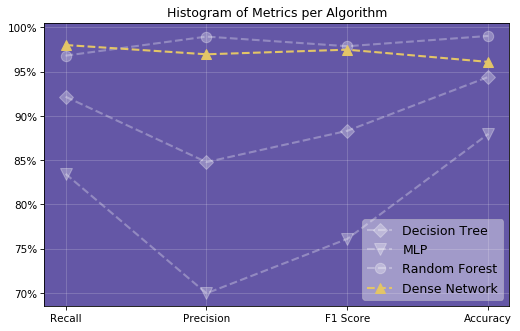

In [304]:
fig, ax = plt.subplots(figsize=(8, 5))

'''ax.plot(metrics_df.index, metrics_df['SVM'], color='white', 
        marker='s', ms=10, linewidth=2, linestyle='dashed', alpha=0.3)'''

ax.plot(metrics_df.index, metrics_df['Decision Tree'], color='white', 
        marker='D', ms=10, linewidth=2, linestyle='dashed', alpha=0.3)

ax.plot(metrics_df.index, metrics_df['MLP'], color='white', 
        marker='v', ms=12, linewidth=2, linestyle='dashed', alpha=0.3)

ax.plot(metrics_df.index, metrics_df['Random Forest'], color='white', 
        marker='o', ms=10, linewidth=2, linestyle='dashed', alpha=3e-1)

ax.plot(metrics_df.index, metrics_df['Dense Network'], color='#E3C567', 
        marker='^', ms=10, linewidth=2, linestyle='dashed')

ax.legend(['Decision Tree', 'MLP', 'Random Forest', 'Dense Network'], 
          fontsize='large', framealpha=.4, loc='lower right')
ax.set_yticklabels(['{:.0%}'.format(x) for x in ax.get_yticks()])
plt.title('Histogram of Metrics per Algorithm')
set_theme()
plt.show()

The best model is the random forest. We started with an f1 score of 46% with logistic regression, and now we reached 97.87% with our final model. 